In [1]:
import pandas as pd
import zipfile
import matplotlib.pyplot as pl
import pandas as pd
from shapely.geometry import  Point
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import seaborn as sns
from matplotlib import cm
import urllib.request
import shutil
import zipfile
import os
import re
import contextily as ctx
import geoplot as gplt
import lightgbm as lgb
import eli5
from eli5.sklearn import PermutationImportance
from lightgbm import LGBMClassifier
from matplotlib import pyplot as plt
import shap
from pdpbox import pdp, get_dataset, info_plots


In D:\ProgramFiles\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In D:\ProgramFiles\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In D:\ProgramFiles\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In D:\ProgramFiles\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In D:\ProgramFiles\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The savefig.jpeg_quality rcparam was 

In [3]:
from sklearn.metrics import log_loss

In [4]:
train = pd.read_csv(open('train.csv'), parse_dates=['Dates'])

In [5]:
test = pd.read_csv(open('test.csv'), parse_dates=['Dates'], index_col = "Id")

In [6]:
sub = pd.read_csv(open('sampleSubmission.csv'))

                Dates        Category                      Descript  \
0 2015-05-13 23:53:00        WARRANTS                WARRANT ARREST   
1 2015-05-13 23:53:00  OTHER OFFENSES      TRAFFIC VIOLATION ARREST   
2 2015-05-13 23:33:00  OTHER OFFENSES      TRAFFIC VIOLATION ARREST   
3 2015-05-13 23:30:00   LARCENY/THEFT  GRAND THEFT FROM LOCKED AUTO   
4 2015-05-13 23:30:00   LARCENY/THEFT  GRAND THEFT FROM LOCKED AUTO   

   DayOfWeek PdDistrict      Resolution                    Address  \
0  Wednesday   NORTHERN  ARREST, BOOKED         OAK ST / LAGUNA ST   
1  Wednesday   NORTHERN  ARREST, BOOKED         OAK ST / LAGUNA ST   
2  Wednesday   NORTHERN  ARREST, BOOKED  VANNESS AV / GREENWICH ST   
3  Wednesday   NORTHERN            NONE   1500 Block of LOMBARD ST   
4  Wednesday       PARK            NONE  100 Block of BRODERICK ST   

            X          Y  Year  Week  Hour  
0 -122.425892  37.774599  2015    20    23  
1 -122.425892  37.774599  2015    20    23  
2 -122.424363  37

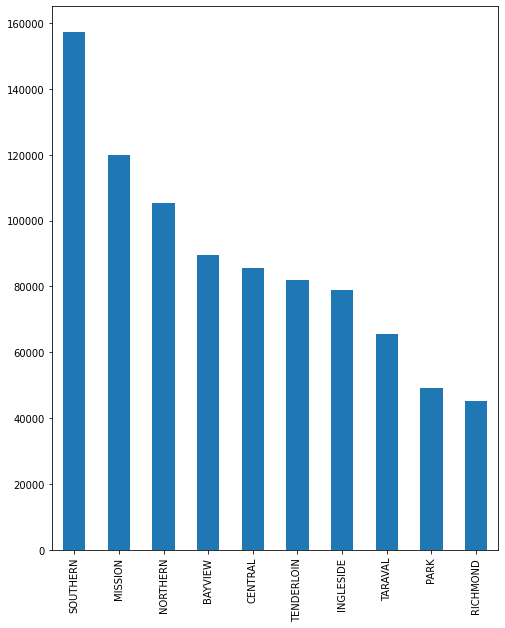

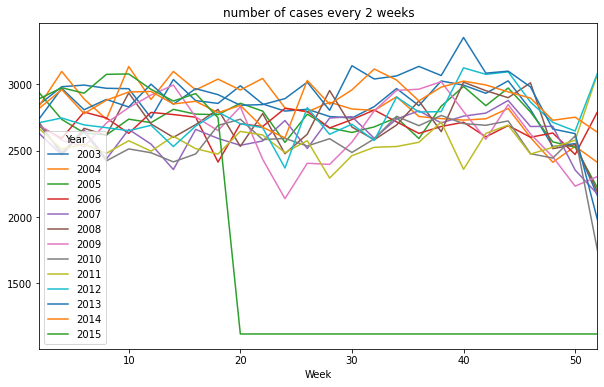

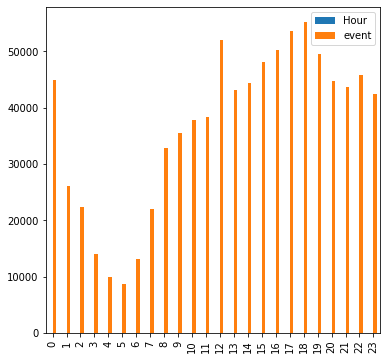

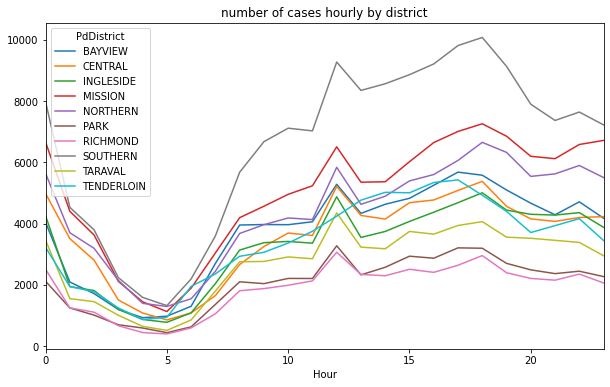

In [7]:
train['Year'] = train['Dates'].map(lambda x: x.year)
train['Week'] = train['Dates'].map(lambda x: x.week)
train['Hour'] = train['Dates'].map(lambda x: x.hour)

print(train.head())

# District Count Plot
train.PdDistrict.value_counts().plot(kind='bar', figsize=(8,10))
pl.savefig('district_counts.png')

# number of cases every 2 weeks
train['event']=1
weekly_events = train[['Week','Year','event']].groupby(['Year','Week']).count().reset_index()
weekly_events_years = weekly_events.pivot(index='Week', columns='Year', values='event').fillna(method='ffill')
#%matplotlib inline
ax = weekly_events_years.interpolate().plot(title='number of cases every 2 weeks', figsize=(10,6))
pl.savefig('events_every_two_weeks.png')

# hourly_events
hourly_events = train[['Hour','event']].groupby(['Hour']).count().reset_index()
hourly_events.plot(kind='bar', figsize=(6, 6))
pl.savefig('hourly_events.png')

# hourly_district_events_pivot
hourly_district_events = train[['PdDistrict','Hour','event']].groupby(['PdDistrict','Hour']).count().reset_index()
hourly_district_events_pivot = hourly_district_events.pivot(index='Hour', columns='PdDistrict', values='event').fillna(method='ffill')
hourly_district_events_pivot.interpolate().plot(title='number of cases hourly by district', figsize=(10,6))
pl.savefig('hourly_events_by_district.png')

In [10]:
train.head()

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y,Year,Week,Hour,event
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,2015,20,23,1
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,2015,20,23,1
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414,2015,20,23,1
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873,2015,20,23,1
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541,2015,20,23,1


In [7]:
test.head()

,Dates,DayOfWeek,PdDistrict,Address,X,Y
Id,,,,,,
0,2015-05-10 23:59:00,Sunday,BAYVIEW,2000 Block of THOMAS AV,-122.399588,37.735051
1,2015-05-10 23:51:00,Sunday,BAYVIEW,3RD ST / REVERE AV,-122.391523,37.732432
2,2015-05-10 23:50:00,Sunday,NORTHERN,2000 Block of GOUGH ST,-122.426002,37.792212
3,2015-05-10 23:45:00,Sunday,INGLESIDE,4700 Block of MISSION ST,-122.437394,37.721412
4,2015-05-10 23:45:00,Sunday,INGLESIDE,4700 Block of MISSION ST,-122.437394,37.721412


In [11]:
sub.head(250)

,Id,ARSON,ASSAULT,BAD CHECKS,BRIBERY,BURGLARY,DISORDERLY CONDUCT,DRIVING UNDER THE INFLUENCE,DRUG/NARCOTIC,DRUNKENNESS,...,SEX OFFENSES NON FORCIBLE,STOLEN PROPERTY,SUICIDE,SUSPICIOUS OCC,TREA,TRESPASS,VANDALISM,VEHICLE THEFT,WARRANTS,WEAPON LAWS
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,245,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
246,246,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
247,247,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
248,248,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [12]:
sub.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 884262 entries, 0 to 884261
Data columns (total 40 columns):
Id                             884262 non-null int64
ARSON                          884262 non-null int64
ASSAULT                        884262 non-null int64
BAD CHECKS                     884262 non-null int64
BRIBERY                        884262 non-null int64
BURGLARY                       884262 non-null int64
DISORDERLY CONDUCT             884262 non-null int64
DRIVING UNDER THE INFLUENCE    884262 non-null int64
DRUG/NARCOTIC                  884262 non-null int64
DRUNKENNESS                    884262 non-null int64
EMBEZZLEMENT                   884262 non-null int64
EXTORTION                      884262 non-null int64
FAMILY OFFENSES                884262 non-null int64
FORGERY/COUNTERFEITING         884262 non-null int64
FRAUD                          884262 non-null int64
GAMBLING                       884262 non-null int64
KIDNAPPING                     884262 non

In [13]:
print('First date: ', str(train.Dates.describe()['first']))
print('Last date: ', str(train.Dates.describe()['last']))
print('Test data shape ', train.shape)
print("Types" , train.dtypes)

First date:  2003-01-06 00:01:00
Last date:  2015-05-13 23:53:00
Test data shape  (878049, 13)
Types Dates         datetime64[ns]
Category              object
Descript              object
DayOfWeek             object
PdDistrict            object
Resolution            object
Address               object
X                    float64
Y                    float64
Year                   int64
Week                   int64
Hour                   int64
event                  int64
dtype: object


In [14]:
print("duplicated variables : ",train.duplicated().sum())
# delete duplicated variables

duplicated variables :  2323


##### We will also evaluate the position of the data points using the coordinates.

In [15]:
def create_gdf(df):
    gdf = df.copy()
    gdf['Coordinates'] = list(zip(gdf.X, gdf.Y))
    gdf.Coordinates = gdf.Coordinates.apply(Point)
    gdf = gpd.GeoDataFrame(
        gdf, geometry='Coordinates', crs={'init': 'epsg:4326'})
    return gdf

train_gdf = create_gdf(train)

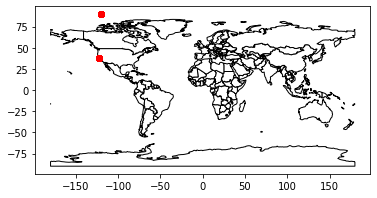

In [16]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
ax = world.plot(color='white', edgecolor='black')
train_gdf.plot(ax=ax, color='red')
plt.show()

In [17]:
# Some points are misplaced. Let's see how many they are.

In [18]:
print(train_gdf.loc[train_gdf.Y > 50].count()[0])
train_gdf.loc[train_gdf.Y > 50].sample(5)

67


,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y,Year,Week,Hour,event,Coordinates
842259,2003-06-25 07:30:00,VEHICLE THEFT,STOLEN AUTOMOBILE,Wednesday,RICHMOND,NONE,JOHN F KENNEDY DR / MARTIN LUTHER KING JR DR,-120.5,90.0,2003,26,7,1,POINT (-120.50000 90.00000)
798834,2004-01-24 14:00:00,LARCENY/THEFT,GRAND THEFT PICKPOCKET,Saturday,CENTRAL,NONE,GREENWICH ST / THE EMBARCADERO NORTH ST,-120.5,90.0,2004,4,14,1,POINT (-120.50000 90.00000)
661106,2005-12-29 00:07:00,NON-CRIMINAL,"AIDED CASE, MENTAL DISTURBED",Thursday,TENDERLOIN,PSYCHOPATHIC CASE,5THSTNORTH ST / EDDY ST,-120.5,90.0,2005,52,0,1,POINT (-120.50000 90.00000)
842828,2003-06-23 19:00:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Monday,NORTHERN,NONE,LARKIN ST / AUSTIN ST,-120.5,90.0,2003,26,19,1,POINT (-120.50000 90.00000)
675288,2005-10-18 10:15:00,SUSPICIOUS OCC,SUSPICIOUS OCCURRENCE,Tuesday,CENTRAL,NONE,MONTGOMERY ST / THE EMBARCADERONORTH ST,-120.5,90.0,2005,42,10,1,POINT (-120.50000 90.00000)


In [19]:
train.drop_duplicates(inplace=True)
train.replace({'X': -120.5, 'Y': 90.0}, np.NaN, inplace=True)
test.replace({'X': -120.5, 'Y': 90.0}, np.NaN, inplace=True)

imp = SimpleImputer(strategy='mean')

for district in train['PdDistrict'].unique():
    train.loc[train['PdDistrict'] == district, ['X', 'Y']] = imp.fit_transform(
        train.loc[train['PdDistrict'] == district, ['X', 'Y']])
    test.loc[test['PdDistrict'] == district, ['X', 'Y']] = imp.transform(
        test.loc[test['PdDistrict'] == district, ['X', 'Y']])

train_gdf = create_gdf(train)

#### Dates & Day of the week
* These variables are distributed uniformly between 1/1/2003 to 5/13/2015 (and Monday to Sunday) and split between the training and the testing dataset as mentioned before. We did not notice any anomalies on these variables.
* The median frequency of incidents is 389 per day with a standard deviation of 48.51.

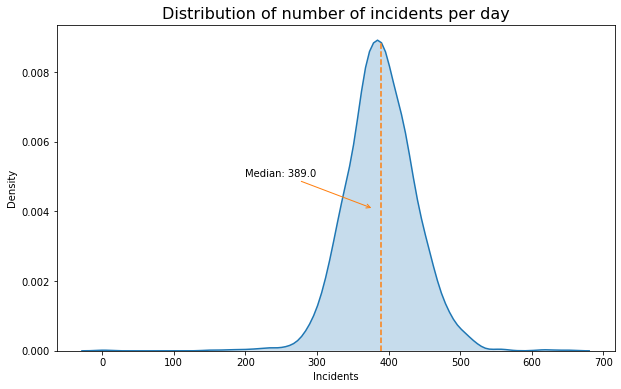

In [20]:
col = sns.color_palette()

train['Date'] = train.Dates.dt.date
train['Hour'] = train.Dates.dt.hour

plt.figure(figsize=(10, 6))
data = train.groupby('Date').count().iloc[:, 0]
sns.kdeplot(data=data, shade=True)
plt.axvline(x=data.median(), ymax=0.95, linestyle='--', color=col[1])
plt.annotate(
    'Median: ' + str(data.median()),
    xy=(data.median(), 0.004),
    xytext=(200, 0.005),
    arrowprops=dict(arrowstyle='->', color=col[1], shrinkB=10))
plt.title(
    'Distribution of number of incidents per day', fontdict={'fontsize': 16})
plt.xlabel('Incidents')
plt.ylabel('Density')
plt.legend().remove()
plt.show()

Also, there is no significant deviation of incidents frequency throughout the week. Thus we do not expect this variable to play a significant role in the prediction.

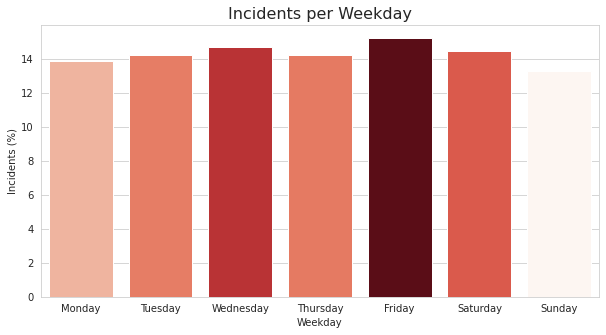

In [21]:
day_of_week_data = train.groupby('DayOfWeek').count().iloc[:, 0]
day_of_week_data = day_of_week_data.reindex([
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday',
    'Sunday'
])
plt.figure(figsize=(10, 5))
with sns.axes_style("whitegrid"):
    ax = sns.barplot(
        day_of_week_data.index, (day_of_week_data.values / day_of_week_data.values.sum()) * 100,
        orient='v',
        palette=cm.ScalarMappable(cmap='Reds').to_rgba(day_of_week_data.values))

plt.title('Incidents per Weekday', fontdict={'fontsize': 16})
plt.xlabel('Weekday')
plt.ylabel('Incidents (%)')

plt.show()

In [22]:
day_of_week_data

DayOfWeek
Monday       121303
Tuesday      124603
Wednesday    128829
Thursday     124757
Friday       133371
Saturday     126469
Sunday       116394
Name: Dates, dtype: int64

#### Category
There are 39 discrete categories that the police department file the incidents with the most common being Larceny/Theft (19.91%), Non/Criminal (10.50%), and Assault(8.77%).

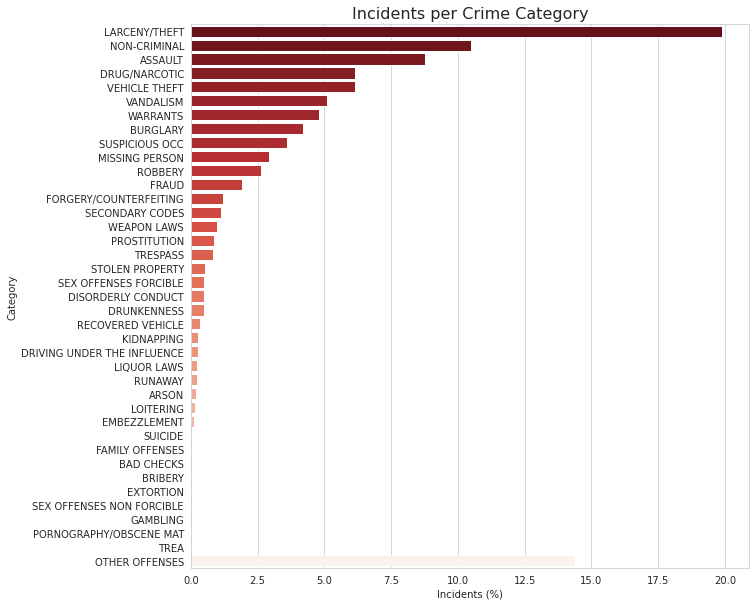

In [23]:
cat_data = train.groupby('Category').count().iloc[:, 0].sort_values(
    ascending=False)
cat_data = cat_data.reindex(np.append(np.delete(cat_data.index, 1), 'OTHER OFFENSES'))

plt.figure(figsize=(10, 10))
with sns.axes_style("whitegrid"):
    ax = sns.barplot(
        (cat_data.values / cat_data.values.sum()) * 100,
        cat_data.index,
        orient='h',
        palette="Reds_r")

plt.title('Incidents per Crime Category', fontdict={'fontsize': 16})
plt.xlabel('Incidents (%)')

plt.show()

In [24]:
cat_data

Category
LARCENY/THEFT                  174320
NON-CRIMINAL                    91915
ASSAULT                         76815
DRUG/NARCOTIC                   53919
VEHICLE THEFT                   53706
VANDALISM                       44581
WARRANTS                        42145
BURGLARY                        36600
SUSPICIOUS OCC                  31394
MISSING PERSON                  25669
ROBBERY                         22988
FRAUD                           16637
FORGERY/COUNTERFEITING          10592
SECONDARY CODES                  9979
WEAPON LAWS                      8550
PROSTITUTION                     7446
TRESPASS                         7318
STOLEN PROPERTY                  4537
SEX OFFENSES FORCIBLE            4380
DISORDERLY CONDUCT               4313
DRUNKENNESS                      4277
RECOVERED VEHICLE                3132
KIDNAPPING                       2340
DRIVING UNDER THE INFLUENCE      2268
LIQUOR LAWS                      1899
RUNAWAY                          1894
ARS

#### Police District
There are significant differences between the different districts of the City with the Southern district having the most incidents (17.87%) followed by Mission (13.67%) and Northern (12.00%).

In [25]:
url = 'https://data.sfgov.org/api/geospatial/wkhw-cjsf?method=export&format=Shapefile'
with urllib.request.urlopen(url) as response, open('pd_data.zip', 'wb') as out_file:
    shutil.copyfileobj(response, out_file)
# Unzipping it
with zipfile.ZipFile('pd_data.zip', 'r') as zip_ref:
    zip_ref.extractall('pd_data')
# Loading to a geopandas dataframe
for filename in os.listdir('./pd_data/'):
    if re.match(".+\.shp", filename):
        pd_districts = gpd.read_file('./pd_data/'+filename)
        break
# Defining the coordinate system to longitude/latitude
pd_districts.crs={'init': 'epsg:4326'}

# Merging our train dataset with the geo-dataframe
pd_districts = pd_districts.merge(
    train.groupby('PdDistrict').count().iloc[:, [0]].rename(
        columns={'Dates': 'Incidents'}),
    how='inner',
    left_on='district',
    right_index=True,
    suffixes=('_x', '_y'))

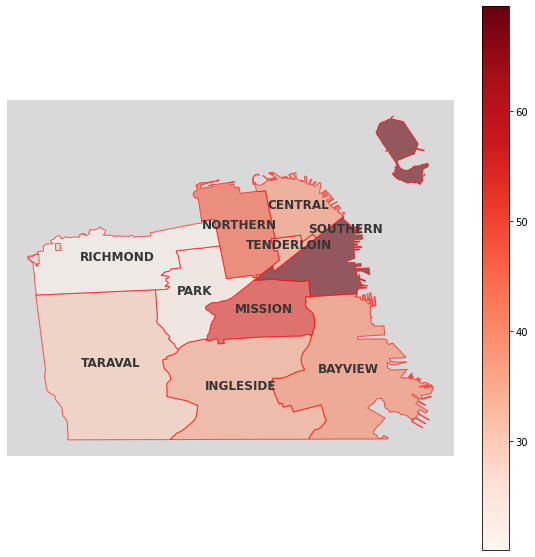

In [26]:
# Calculating the incidents per day for every district
train_days = train.groupby('Date').count().shape[0]
pd_districts['inc_per_day'] = pd_districts.Incidents/train_days

# Ploting the data
fig, ax = plt.subplots(figsize=(10, 10))
pd_districts.plot(
    column='inc_per_day',
    cmap='Reds',
    alpha=0.6,
    edgecolor='r',
    linestyle='-',
    linewidth=1,
    legend=True,
    ax=ax)

def add_basemap(ax, zoom, url='http://tile.stamen.com/terrain/tileZ/tileX/tileY.png'):
    """Function that add the tile background to the map"""
    xmin, xmax, ymin, ymax = ax.axis()
    basemap, extent = ctx.bounds2img(xmin, ymin, xmax, ymax, zoom=zoom, url=url)
    ax.imshow(basemap, extent=extent, interpolation='bilinear')
    # restore original x/y limits
    ax.axis((xmin, xmax, ymin, ymax))

# Adding the background
add_basemap(ax, zoom=11, url=ctx.sources.ST_TONER_LITE)

# Adding the name of the districts
for index in pd_districts.index:
    plt.annotate(
        pd_districts.loc[index].district,
        (pd_districts.loc[index].geometry.centroid.x,
         pd_districts.loc[index].geometry.centroid.y),
        color='#353535',
        fontsize='large',
        fontweight='heavy',
        horizontalalignment='center'
    )

ax.set_axis_off()
plt.show()

#### Address
Address, as a text field, requires advanced techniques to use it for the prediction. Instead in this project, we will use it to extract if the incident has happened on the road or in a building block.

#### X - Longitude Y - Latitude
We have tested that the coordinates belong inside the boundaries of the city. Although longitude does not contain any outliers, latitude includes some 90o values which correspond to the North Pole.

#### Exploratory Visualization
Based on the Project’s statement, we need to predict the probability of each type of crime based on time and location. That being said, we present two diagrams to visualize the importance of these variables. The first one presents the geographic density of 9 random crime categories. We can see that although the epicenter of most of the crimes resides on the northeast of the city, each crime has a different density on the rest of the city. This fact is a reliable indication that the location ( coordinates / Police District) will be a significant factor for the analysis and the forecasting.

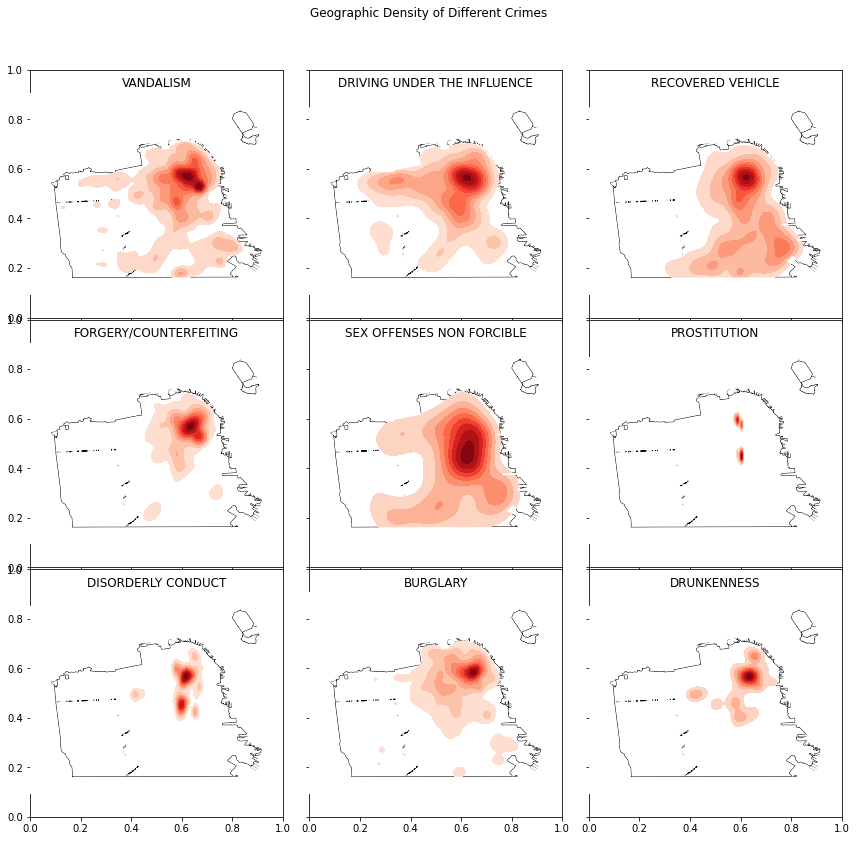

In [27]:
crimes = train['Category'].unique().tolist()
crimes.remove('TREA')


sf_land = pd_districts.unary_union
sf_land = gpd.GeoDataFrame(gpd.GeoSeries(sf_land), crs={'init':'epsg:4326'})
sf_land = sf_land.rename(columns={0:'geometry'}).set_geometry('geometry')

fig, ax = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(12,12))
for i , crime in enumerate(np.random.choice(crimes, size=9, replace=False)):
    data = train_gdf.loc[train_gdf['Category'] == crime]
    ax = fig.add_subplot(3, 3, i+1)
    gplt.kdeplot(data,
                 shade=True,
                 shade_lowest=False,
                 clip = sf_land.geometry,
                 cmap='Reds',
                 ax=ax)
    gplt.polyplot(sf_land, ax=ax)
    ax.set_title(crime) 
plt.suptitle('Geographic Density of Different Crimes')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

The second diagram presents the average number of incidents per hour for five of the crimes' categories. It is evident that different crimes have different frequency during different times of the day. Some examples are that prostitution picks during the evening and all through the night, Gambling incidents start late at night until the morning and Burglary picks early in the morning until the afternoon. As before these are sharp pieces of evidence that the time parameters will have a significant role also.

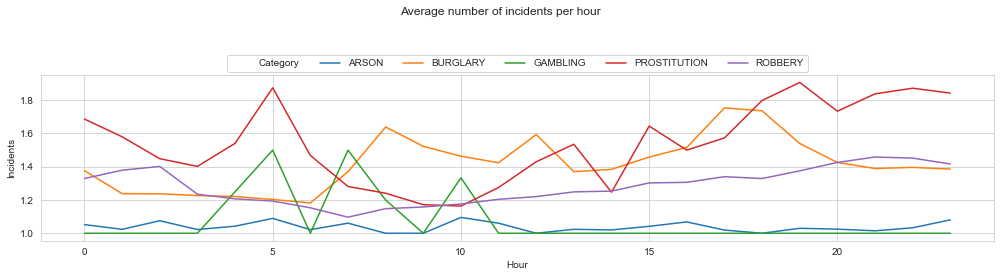

In [28]:
data = train.groupby(['Hour', 'Date', 'Category'],
                     as_index=False).count().iloc[:, :4]
data.rename(columns={'Dates': 'Incidents'}, inplace=True)
data = data.groupby(['Hour', 'Category'], as_index=False).mean()
data = data.loc[data['Category'].isin(
    ['ROBBERY', 'GAMBLING', 'BURGLARY', 'ARSON', 'PROSTITUTION'])]

sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(14, 4))
ax = sns.lineplot(x='Hour', y='Incidents', data=data, hue='Category')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=6)
plt.suptitle('Average number of incidents per hour')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

#### Benchmark
* There are two types of benchmarks we need to set. The first will be a naive prediction. This prediction will be a baseline score to compare with our model’s score to evaluate if we have any significant progress.

* In a Multiclass Classification, the best way to calculate the baseline is by assuming that the probability of each category equals its average frequency in the train set. The frequency can be calculated easily by dividing the sum of incidents of each category by the number of rows of the training set.

In [29]:
naive_vals = train.groupby('Category').count().iloc[:,0]/train.shape[0]
n_rows = test.shape[0]

submission = pd.DataFrame(
    np.repeat(np.array(naive_vals), n_rows).reshape(39, n_rows).transpose(),
    columns=naive_vals.index)

In [30]:
submission

Category,ARSON,ASSAULT,BAD CHECKS,BRIBERY,BURGLARY,DISORDERLY CONDUCT,DRIVING UNDER THE INFLUENCE,DRUG/NARCOTIC,DRUNKENNESS,EMBEZZLEMENT,...,SEX OFFENSES NON FORCIBLE,STOLEN PROPERTY,SUICIDE,SUSPICIOUS OCC,TREA,TRESPASS,VANDALISM,VEHICLE THEFT,WARRANTS,WEAPON LAWS
0,0.001727,0.087716,0.000464,0.00033,0.041794,0.004925,0.00259,0.061571,0.004884,0.001329,...,0.000169,0.005181,0.00058,0.035849,0.000007,0.008356,0.050907,0.061327,0.048126,0.009763
1,0.001727,0.087716,0.000464,0.00033,0.041794,0.004925,0.00259,0.061571,0.004884,0.001329,...,0.000169,0.005181,0.00058,0.035849,0.000007,0.008356,0.050907,0.061327,0.048126,0.009763
2,0.001727,0.087716,0.000464,0.00033,0.041794,0.004925,0.00259,0.061571,0.004884,0.001329,...,0.000169,0.005181,0.00058,0.035849,0.000007,0.008356,0.050907,0.061327,0.048126,0.009763
3,0.001727,0.087716,0.000464,0.00033,0.041794,0.004925,0.00259,0.061571,0.004884,0.001329,...,0.000169,0.005181,0.00058,0.035849,0.000007,0.008356,0.050907,0.061327,0.048126,0.009763
4,0.001727,0.087716,0.000464,0.00033,0.041794,0.004925,0.00259,0.061571,0.004884,0.001329,...,0.000169,0.005181,0.00058,0.035849,0.000007,0.008356,0.050907,0.061327,0.048126,0.009763
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
884257,0.001727,0.087716,0.000464,0.00033,0.041794,0.004925,0.00259,0.061571,0.004884,0.001329,...,0.000169,0.005181,0.00058,0.035849,0.000007,0.008356,0.050907,0.061327,0.048126,0.009763
884258,0.001727,0.087716,0.000464,0.00033,0.041794,0.004925,0.00259,0.061571,0.004884,0.001329,...,0.000169,0.005181,0.00058,0.035849,0.000007,0.008356,0.050907,0.061327,0.048126,0.009763
884259,0.001727,0.087716,0.000464,0.00033,0.041794,0.004925,0.00259,0.061571,0.004884,0.001329,...,0.000169,0.005181,0.00058,0.035849,0.000007,0.008356,0.050907,0.061327,0.048126,0.009763
884260,0.001727,0.087716,0.000464,0.00033,0.041794,0.004925,0.00259,0.061571,0.004884,0.001329,...,0.000169,0.005181,0.00058,0.035849,0.000007,0.008356,0.050907,0.061327,0.048126,0.009763


* The baseline calculated this way is 2.68015. (Details in SF-Crime Analysis & Prediction (Naive Prediction) Notebook. We can notice that this baseline is already lower than the initial score of our classifiers.

* Another critical benchmark is usually the ‘Human Performance’, as a proxy for the Bayes error rate. The specific problem does not belong to a field that humans excel (like computer vision or NLP), so as a proxy for the Bayes error rate, we will use the score of the best kernel so far which is initial benchmark need tuning by the user Sergey Lebedev with score 2.29318.

* The small distance between the baseline score and the Bayes error rate indicate that this is a hard problem with a low margin of improvement.

#### Data Preprocessing
##### Data Wrangling
Following the methodology described in the Problem Statement, we identified 2323 duplicate values and 67 wrong latitudes. The duplicates removed and the outliers imputed.

###### Feature Engineering
Then, we created additional features. More specifically:

From the ‘Dates’ field, we extracted the Day, the Month, the Year, the Hour, the Minute, the Weekday, and the number of days since the first day in the data.
From the ‘Address’ field we extracted if the incident has taken place in a crossroad or on a building block.

In [31]:
def feature_engineering(data):
    data['Date'] = pd.to_datetime(data['Dates'].dt.date)
    data['n_days'] = (
        data['Date'] - data['Date'].min()).apply(lambda x: x.days)
    data['Day'] = data['Dates'].dt.day
    data['DayOfWeek'] = data['Dates'].dt.weekday
    data['Month'] = data['Dates'].dt.month
    data['Year'] = data['Dates'].dt.year
    data['Hour'] = data['Dates'].dt.hour
    data['Minute'] = data['Dates'].dt.minute
    data['Block'] = data['Address'].str.contains('block', case=False)
    
    data.drop(columns=['Dates','Date','Address'], inplace=True)
        
    return data

In [32]:
train = feature_engineering(train)
train.drop(columns=['Descript','Resolution'], inplace=True)
test = feature_engineering(test)
train.head()

,Category,DayOfWeek,PdDistrict,X,Y,Year,Week,Hour,event,n_days,Day,Month,Minute,Block
0,WARRANTS,2,NORTHERN,-122.425892,37.774599,2015,20,23,1,4510,13,5,53,False
1,OTHER OFFENSES,2,NORTHERN,-122.425892,37.774599,2015,20,23,1,4510,13,5,53,False
2,OTHER OFFENSES,2,NORTHERN,-122.424363,37.800414,2015,20,23,1,4510,13,5,33,False
3,LARCENY/THEFT,2,NORTHERN,-122.426995,37.800873,2015,20,23,1,4510,13,5,30,True
4,LARCENY/THEFT,2,PARK,-122.438738,37.771541,2015,20,23,1,4510,13,5,30,True


In [33]:
print(train["n_days"].unique())

[4510 4509 4508 ...    2    1    0]


In [34]:
le1 = LabelEncoder()
train['PdDistrict'] = le1.fit_transform(train['PdDistrict'])
test['PdDistrict'] = le1.transform(test['PdDistrict'])
le2 = LabelEncoder()
y = le2.fit_transform(train.pop('Category'))

train_X, val_X, train_y, val_y = train_test_split(train, y)

model =LGBMClassifier(objective='multiclass', num_class=39).fit(train_X, train_y)

perm = PermutationImportance(model).fit(val_X, val_y)
eli5.show_weights(perm, feature_names=val_X.columns.tolist())

Weight,Feature
0.0590 ± 0.0014,Minute
0.0552 ± 0.0009,Y
0.0416 ± 0.0007,X
0.0209 ± 0.0002,Block
0.0177 ± 0.0006,n_days
0.0169 ± 0.0004,Hour
0.0152 ± 0.0002,PdDistrict
0.0074 ± 0.0002,Week
0.0072 ± 0.0003,Year
0.0055 ± 0.0006,Month


In [78]:
perm

PermutationImportance(estimator=LGBMClassifier(num_class=39,
                                               objective='multiclass'))

In [71]:
train = pd.read_csv('train.csv', parse_dates=['Dates'])
test = pd.read_csv('test.csv', parse_dates=['Dates'], index_col='Id')

# Data cleaning
train.drop_duplicates(inplace=True)
train.replace({'X': -120.5, 'Y': 90.0}, np.NaN, inplace=True)
test.replace({'X': -120.5, 'Y': 90.0}, np.NaN, inplace=True)

imp = SimpleImputer(strategy='mean')

for district in train['PdDistrict'].unique():
    train.loc[train['PdDistrict'] == district, ['X', 'Y']] = imp.fit_transform(
        train.loc[train['PdDistrict'] == district, ['X', 'Y']])
    test.loc[test['PdDistrict'] == district, ['X', 'Y']] = imp.transform(
        test.loc[test['PdDistrict'] == district, ['X', 'Y']])
train_data = lgb.Dataset(
    train, label=y, categorical_feature=['PdDistrict'], free_raw_data=False)

# Feature Engineering
train = feature_engineering(train)
train.drop(columns=['Descript','Resolution'], inplace=True)
test = feature_engineering(test)

# Encoding the Categorical Variables
le1 = LabelEncoder()
train['PdDistrict'] = le1.fit_transform(train['PdDistrict'])
test['PdDistrict'] = le1.transform(test['PdDistrict'])

le2 = LabelEncoder()
X = train.drop(columns=['Category'])
y= le2.fit_transform(train['Category'])

# Creating the model
train_data = lgb.Dataset(
    X, label=y, categorical_feature=['PdDistrict'])

params = {'boosting':'gbdt',
          'objective':'multiclass',
          'num_class':39,
          'max_delta_step':0.9,
          'min_data_in_leaf': 21,
          'learning_rate': 0.4,
          'max_bin': 465,
          'num_leaves': 41
         }

bst = lgb.train(params, train_data, 100)

predictions = bst.predict(test)

# Submitting the results
submission = pd.DataFrame(
    predictions,
    columns=le2.inverse_transform(np.linspace(0, 38, 39, dtype='int16')),
    index=test.index)
submission.to_csv(
    'LGBM_final.csv', index_label='Id')

In [74]:
np.shape(predictions)

(884262, 39)

In [77]:
y

array([37, 21, 21, ..., 16, 35, 12])